# Lab 4. Introducere PyTorch

### Ce este PyTorch?

PyTorch este o biblioteca Python folosita cu doua scopuri:
 * reprezinta un inlocuitor al bibliotecii NumPy, care se poate folosi de puterea computationala a componentelor precum GPUs
 * contine implementarea unui sistem automat de derivare, util pentru antrenarea retelelor neuronale

In [ ]:
# ! pip install torch torchvision

## Tensori

Tensorii sunt o structura de date speciala, asemanatoare vectorilor si matricelor. Tensorii sunt folositi in PyTorch pentru a stoca inputul si outputul modelelor, dar si parametrii modelelor.

Tensorii se aseamana foarte mult cu NumPy arrays, cu diferenta ca pot fi procesati de GPU sau alte tipuri de hardware specializat.

In [ ]:
import torch
import numpy as np

### Initializarea tensorilor

**Folosind Python lists**

In [ ]:
data = [[1, 2], [3, 4]]
t_from_list = torch.tensor(data)
print(t_from_list)

**Folosind NumPy arrays**

In [ ]:
np_array = np.array(data)
t_from_np = torch.from_numpy(np_array)
print(t_from_np)

**Folosind un alt tensor**

Noul tensor retine proprietatile (shape + tip de date) ale tensorului original, daca nu este specificat explicit altfel.

In [ ]:
t_ones = torch.ones_like(t_from_list)  # aceleasi proprietati cu ale lui t_from_list
print(f"Tensor plin de 1:\n{t_ones}\n")

t_rand = torch.rand_like(t_from_list, dtype=torch.float)  # suprascrie tipul de date
print(f"Tensor random:\n{t_rand}\n")

**Folosind valori aleatoare sau constante**

In [ ]:
shape = (2, 3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random tensor:\n{rand_tensor}\n")
print(f"Ones tensor:\n{ones_tensor}\n")
print(f"Zeros tensor:\n{zeros_tensor}\n")

### Proprietatile tensorilor

In [ ]:
tensor = torch.rand(3, 4)

print(f"Shape: {tensor.shape}")
print(f"Tip de date: {tensor.dtype}")
print(f"Device: {tensor.device}")

### Operatii cu tensori

Puteti gasi [aici](https://pytorch.org/docs/stable/torch.html) o lista exhaustiva cu operatii (transpuneri, indexari, slicing, concatenari, operatii matematice, etc.)

Toate aceste operatii pot fi realizate mai rapid cu ajutorul unui GPU.

In [ ]:
# mutam tensorul pe GPU daca avem unul la dispozitie
if torch.cuda.is_available():
    tensor = tensor.to("cuda")
    print(f"Tensorul este stocat acum pe: {tensor.device}")

**Indexdare si slicing (asemanator NumPy)**

In [ ]:
tensor = torch.ones(4, 4)
tensor[:, 1] = 0
print(tensor)

**Concatenare**

In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

**Inmultirea tensorilor**

In [ ]:
# inmultire "element cu element"
tensor = torch.tensor([[0, 2], [2, 0], [2, 2]])
print(f"tensor.mul(tensor)\n{tensor.mul(tensor)}\n")
print(f"tensor * tensor\n{tensor* tensor}\n")

In [ ]:
# inmultire de matrici
# inmultim matricea cu transpusa (tensor.T)
print(f"tensor.matmul(tensor.T)\n{tensor.matmul(tensor.T)}\n")
print(f"tensor @ tensor.T\n{tensor @ tensor.T}\n")

**Operatii in-place**

Operatiile care au `_` ca sufix modifica tensorul pentru care au fost apelate. Exemplu: `x.copy_(y)` sau `x.t_()` il modifica pe `x`.

Aceste metode salveaza memorie insa aduc probleme atunci cand vine vorba de calculul automat al derivatelor operatiilor efectuate (de aceea folosirea lor NU este recomandata).

In [ ]:
print(tensor, "\n")
tensor.add_(5)
print(tensor)

### Legatura cu NumPy

Un tensor stocat pe CPU si un NumPy array pot imparti aceeasi memorie in program, astfel modificarile asupra unuia se reflecta asupra celuilalt.

In [ ]:
# tensor -> np array
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

In [ ]:
# np array -> tensor
n = np.ones(5)
t = torch.from_numpy(n)
print(f"t: {t}")
print(f"n: {n}")

np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

## torch.autograd

`torch.autograd` este motorul de derivare automata folosit de PyTorch pentru antrenarea retelelor neuronale.

### Retele neuronale

Retelele neuronale (NN - Neural Networks) sunt o colectie de functii inlantuite care sunt aplicate asupra unor date de intrare. Aceste functii se definesc prin parametrii (weights and biases), care in PyTorch sunt stocate prin intermediul tensorilor.

Antrenarea unei retele neuronale se face in doi pasi:
 - **forward propagation**: reteaua incearca sa prezica output-ul corect pe baza datelor de intrare. Paseaza datele de intrare prin sirul de functii (input-ul functiei urmatoare este output-ul functiei curente din lista)
 - **backward propagation**: in acest pas parametrii retelei sunt ajustati proportional cu eroare produsa de predictia facuta la pasul forward. Acest lucru este realizat prin a parcurge lista de functii invers, pornind de la output, calculand la fiecare pas derivata erorii in raport cu parametrii functiilor (acestor derivate le mai spunem gradienti), iar parametrii sunt optimizati folosind coborarea pe gradient (gradient descent).
 
### Implementarea in PyTorch

Vom incerca un singur pas de antrenare. Incarcam un model preantrenat `resnet18` folosit pentru clasificarea de imagini in $1000$ de clase. Cream un tensor random pentru o singura imagine de $64 \times 64$ pixeli cu $3$ canale de culoare. Initializam label-ul acestei imagini cu un tensor random de dimensiune $(1, 1000)$.

In [ ]:
import torchvision

# vom considera pentru moment acest model ca un black-box
# care primeste ca input tensori de forma (batch_size, 3, 64, 64)
# si returneaza pentru fiecare imagine din batch distributia labelurilor pentru acea imagine
# forma outputului este deci: (batch_size, 1000)
model = torchvision.models.resnet18(pretrained=True)

data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [ ]:
# pasul forward
prediction = model(data)

Folosim predictia modelului si labelul corect pentru a calcula eroarea (`loss`). Pasul urmator este propagarea inapoi (backpropagation) a acestei erori prin retea. Acest lucru se realizeaza cand apelam metoda `.backword()` pentru tensorul ce contine eroarea. Motorul `autograd` calculeaza si stocheaza gradientii pentru fircare parametru al modelului in atributul `.grad` al acestor parametrii.

In [ ]:
loss = (prediction - labels).sum()
loss.backward()  # pasul backward

Apoi, incarcam un algoritm de optimizare a parametrilor (optimizer), in cazul de fata [SGD](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) (Stochastic Gradient Descent) cu learning rate de $0.01$ si momentum $0.9$.

Mai intai inregistram toti parametrii modelului in optimizer.

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In cele din urma, apelam `.step()` pentru optimizer pentru a initia algoritmul de coborare pe gradient. Optimizerul ajusteaza astfel fiecare parametru al modelului pe baza gradientilor calculati la pasul backward.

In [ ]:
optim.step()  # gradient descent

[Alti](https://pytorch.org/docs/stable/optim.html) optimizeri utili.

### Derivarea automata in Autograd

In exemplele urmatoare vom vedea cum `autograd` colecteaza si calculeaza gradientii. Cream doi tensori cu atributul `requires_grad` setat pe `True`. Acest lucru semnalizeaza motorului `autograd` ca toate operatiile in care sunt implicati acesti tensori trebuie urmarite (tracked).

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Cream acum un tensor care retine o operatie intre `a` si `b`.
$$Q = 3a^3-b^2$$

In [ ]:
Q = 3 * a**3 - b**2

Daca presupunem ca $a$ si $b$ ar fi parametrii unei retele si $Q$ ar fie eroarea, la antrenare ne intereseaza derivata erorii in raport cu fiecare parametru in parte:

$$\frac{\partial Q}{\partial a} = 9a^2$$

$$\frac{\partial Q}{\partial b} = -2b$$

Cand apelam `.backward()` pentru `Q`, `autograd` calculeaza acesti gradienti si ii salveza in atributul `.grad` al tensorilor corespunzatori.

In acest exemplu trebuie sa pasam explicit un argument `gradient` functiei `Q.backward()` intrucat `Q` este vector. `gradient` este un tensor de aceeasi forma ca si `Q` si reprezinta derivata lui $Q$ in raport cu el insusi:

$$\frac{\partial Q}{\partial Q} = 1$$

Alternativ, putem agrega $Q$ intr-o valoare scalara si sa aplicam `backward` fara a mai specifica gradientul initial: `Q.sum().backward()`.

In [ ]:
# Q este vector specificam derivata cu el insusi
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

# agregam Q intr-un scalar
# Q.sum().backward()

Gradientii sunt stocati acum in `a.grad` si `b.grad`.

In [ ]:
print(f"9a^2 = {9 * a ** 2}")
print(f"dQ/da = {a.grad}\n")
print(f"-2b = {-2 * b}")
print(f"dQ/db = {b.grad}")

### Graful computatiilor

Conceptual, `autograd` retine tensorii si toate operatiile executate asupra acestora, impreuna cu rezultatele intermediare, sub forma unui graf orientat aciclic (DAG - Directed Acyclic Graph) in care nodurile sunt obiecte de tip [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function). In acest DAG, frunzele sunt tensorii din input, iar radacina/radacinile sunt tensorii output. Parcurgand drumuri in acest graf de la radacini la frunze, gradientii pot fi calculati automat folosind "chain rule":

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}$$

In pasul forward, `autograd`:
 * calculeaza rezultatul operatiei curente intr-un tensor
 * mentine functia derivata a acestei operatii in DAG, in atributul `.grad_fn` al tensorului rezultat
 
Pasul backward incepe cand este apelata metoda `.backward()` pentru o radacina din DAG. Atunci, `autograd`:
 * calculeaza fiecare gradient folosind `.grad_fn`
 * acumuleaza gradientul in atributul `.grad` al tensorului respectiv
 * folosind "chain rule" propaga gradientii pana la frunze
 
Reprezentarea DAG-ului pentru calculul de mai devreme al lui `Q` este aceasta:

![](https://pytorch.org/tutorials/_images/dag_autograd.png)

In [ ]:
fn = Q.grad_fn
print(fn)
print(fn.next_functions)

### Excluderea din DAG

`autograd` urmareste operatiile efectuate pe toti tensorii care au `requires_grad=True`. Pentru tensorii ca nu au nevoie de gradienti, setarea acestui atribut cu `False` ii exclude din DAG.

Tensorul output al unei operatii va avea `requires_grad=True` daca macar un tensor input are de asemenea `requires_grad=True`.

In [ ]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"a.requires_grad: {a.requires_grad}")
b = x + z
print(f"b.requires_grad: {b.requires_grad}")

## Pasii de antrenare a unui model

Vom ilustra pasii ce trebuie urmati in cazul in care vrem sa definim si antrenam un model pentru o problema simpla de clasificare.

Mai intai vom defini datele noastre, un set foarte mic de date clasificate in 3 clase.

In [ ]:
dummy_data = {
    "vectors": [
        torch.tensor([0., 0., 0., 0., 0., 0., 2., 3., 4.]),
        torch.tensor([0., 0., 0., 0., 0., 0., 4., 2., 5.]),
        torch.tensor([0., 0., 0., 0., 0., 0., 7., 9., 1.]),
        torch.tensor([0., 0., 0., 4., 5., 2., 0., 0., 0.]),
        torch.tensor([0., 0., 0., 2., 4., 6., 0., 0., 0.]),
        torch.tensor([0., 0., 0., 2., 3., 5., 0., 0., 0.]),
        torch.tensor([2., 9., 6., 0., 0., 0., 0., 0., 0.]),
        torch.tensor([6., 5., 4., 0., 0., 0., 0., 0., 0.]),
        torch.tensor([7., 7., 4., 0., 0., 0., 0., 0., 0.]),
    ],
    "labels": [0, 0, 0, 1, 1, 1, 2, 2, 2],
}

### PyTorch Dataset

Vom incarca setul nostru de date intr-un obiect din clasa [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset).

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    # urmatoarele doua metode trebuie implementate
    def __getitem__(self, k):
        """Returneaza al k-lea exemplu din dataset"""
        return (
            self.data["vectors"][k],
            self.data["labels"][k]
        )
    
    def __len__(self):
        """Returneaza dimensiunea datasetului"""
        return len(self.data["labels"])

In [ ]:
dummy_dataset = MyDataset(dummy_data)
len(dummy_dataset)

### PyTorch DataLoader

In timpul antrenarii vrem sa parcurgem exemplele din dataset si sa le trecem prin reteaua noastra. In practica, mai multe exemple sunt trecute prin retea inainte de a apela pasul backward. Un astfel de grup se numeste batch.

DataLoaderul este un iterator construit plecand de la dataset, care grupeaza mai multe exemple in batch-uri.

In [ ]:
dummy_dataloader = torch.utils.data.DataLoader(dummy_dataset, batch_size=2, shuffle=True)

In [ ]:
next(iter(dummy_dataloader))

### Definitia modelului

Dupa cum am spus mai devreme, un model este o inlantuire de functii (sau straturi/layere). Pentru a defini un model implementam o clasa care mosteneste clasa `torch.nn.Module` si implementam constructorul acesteia in care definim layerele si metoda `forward` in care descriem cum sunt aplicate aceste layere.

Vom implementa un model foarte simplu: un singur layer linear (feed-forward) care primeste un vector de dimensiune $9$ (numarul de features ale datelor noastre) si returneaza un output de dimensiune $3$ (numarul de clase din problema noastra).

Un layer linear este o operatie de forma $y = A \cdot x + b$ (unde matricea $A$ reprezinta weight-urile layerului, iar vectorul $b$, biasul).

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(in_features=9, out_features=3)
        
    def forward(self, x):
        output = self.linear(x)  # aplicam layerul linear
        return output

### Calculul erorii

Pentru un vector de dimensiune $9$ modelul returneaza unul de dimensiune $3$. Cum putem interpreta acest vector pentru a obtine predictiile?

Am putea spre exemplu sa determinam pozitia valorii maxime si sa spunem ca aceea este clasa prezisa de model

In [ ]:
t = torch.tensor([3., 4., 1.])
print("Maxim:\t\t", t.max(0)[0])
print("Poz. maxim:\t", t.max(0)[1])

Insa o varianta mai buna ar fi sa transformam valorile tensorului intr-o distributie de probabilitate (cu ce probabilitate atribuie modelul clasa $i$ exemplului?).

O functie care calculeaza o astfel de distributie pornind de la un tensor oarecare este functia [*softmax*](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html).

In [ ]:
print(torch.nn.functional.softmax(t, dim=0))

Folosind distributia generata de model si labelurile adevarate putem calcula acum eroarea. O functie de eroare des folosita pentru clasificare este [*cross-entropy*](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# presupunem ca aceasta este output-ul modelului pentru un batch de 2 exemple
output = torch.tensor([
    [3., 7., 4.],
    [4., 2., 3.],
])

# si presupunem ca aceastea ar fi labelurile adevarate
true_labels = torch.tensor([1, 1])

print("Labeluri prezise:", output.max(1)[1])

# functia de loss aplica automat softmax peste output-ul modelului
# rezultatul este un scalar corespunzator erorii medii pentru toate exemplele din batch
print("loss: ", loss_fn(output, true_labels))

### O epoca de antrenare

O epoca de antrenare reprezinta parcurgerea datasetului (o data) si actualizarea parametrilor modelului pe baza predictiilor facute. 

In [ ]:
# cuda daca avem la dispozitie GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# initializam modelul si il mutam pe device-ul corespunzator
model = Model().to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# setam modelul in modul de antrenare
model.train()

# parcurgem batch-urile folosind dataloaderul
for (vectors, labels) in dummy_dataloader:
    # mutam vectorii si labelurile pe device-ul corespunzator
    vectors = vectors.to(DEVICE)
    labels = labels.to(DEVICE)
    
    # reseteaza gradientii ramasi de la batch-ul anterior
    optimizer.zero_grad()
    
    # trecem vectorii (batch_size x 9) din batch prin model (forward step)
    output = model(vectors)  # shape: batch_size x 3
    
    # calculam loss-ul
    loss = loss_fn(output, labels)
    
    # backward step
    loss.backward()
    
    # actualizam parametrii modelului folosind optimizerul
    optimizer.step()

Acum putem evalua modelul

In [ ]:
# trecem modelul in modul de evaluare
model.eval()

true_labels = []
predicted_labels = []
mean_loss = 0

for (vectors, labels) in dummy_dataloader:
    vectors = vectors.to(DEVICE)
    labels = labels.to(DEVICE)
    
    output = model(vectors)
    loss = loss_fn(output, labels)
    
    mean_loss += loss.item()
    true_labels.extend(labels.tolist())
    predicted_labels.extend(output.max(1)[1].tolist())

mean_loss /= len(dummy_dataloader)

In [ ]:
import sklearn.metrics as metrics

print("Accuracy:", metrics.accuracy_score(true_labels, predicted_labels))
print("Mean loss:", mean_loss)

#### Important !!!

Retelele neuronale pot obtine destul de usor performanta foarte buna pe datele cu care au fost antrenate, dar fara sa generalizeze (pe date noi, obtin performanta foarte slaba). Numim acest caz **overfit**.

Pentru a stabili clar performanta modelului in practica se realizeaza o impartire a datelor in 3 categorii:
 - train: datele pe care este antrenat modelul la fiecare epoca
 - validare: la finalul fiecarei epoci evaluam performanta modelului pe aceste date (nevazute in timpul antrenarii)
 - test: odata ce am antrenat cel mai bun model (selectat conform datelor de validare) evaluarea finala este facuta pe aceste date (de asemenea, tot nevazute in timpul antrenarii)
 
Datele de validare sunt folosite pentru a monitoriza performanta (loss, acuratete, etc.) modelului la finalul fiecarei epoci. Putem selecta de exemplu parametrii modelului de la finalul epocii cu cea mai bune performanta. De asemenea, daca observam ca eroare pe datele de validare stagneaza sau creste in timp ce eroarea pe datele de train continua sa scade, putem trage concluzia ca modelul a inceput sa faca **overfit** pe datele de train.

### Inlantuirea mai multor layere

Putem defini de exemplu mai multe layere feed-forward (lineare) si sa trecem input-ul succesiv prin ele.

In [ ]:
t_input = torch.tensor([[1., 2., 3., 4., 5.]])  # intotdeauna avem shape (batch_size, dim)

layer_1 = torch.nn.Linear(5, 8)
layer_2 = torch.nn.Linear(8, 4)
layer_3 = torch.nn.Linear(4, 7)

t_output = layer_1(t_input)
t_output = layer_2(t_output)
t_output = layer_3(t_output)

print("Input shape:", t_input.shape)
print("Output shape:", t_output.shape)

#### Functii de activare

Functiile de activare (activation functions / non-linearities) sunt functii aplicate asupra outputului unui layer linear. Motivul pentru care avem nevoie de astfel de functii este faptul ca un layer transforma inputul aplicand o transformare afina ($A \cdot x + b$). Mai multe transformari afine inlantuite sunt echivalente cu o singura transformare (exista un layer `Linear(5, 7)` care ar face aceeasi transformare de mai sus).

Astfel adaugand mai multe layere intermediare nu crestem cu adevarat complexitatea modelului. În cazul de mai sus, fără funcție de activare între straturi, modelul are aceeasi complexitate ca și când ar avea un singur strat Linear, și este foarte probabil să facă [underfitting](https://www.ibm.com/cloud/learn/underfitting). Un model care nu este suficient de complex pentru task și nu reușește să învețe este un model **underfit**.

Functiile de activare sunt functii nelineare derivabile in toate punctele (eventual cu exceptia unui numar finit de puncte). Functii de activare uzuale sunt [ReLU](https://pytorch.org/docs/1.11/generated/torch.nn.ReLU.html#torch.nn.ReLU) si [tanh](https://pytorch.org/docs/1.11/generated/torch.nn.Tanh.html).

In [ ]:
t_input = torch.tensor([[1., 2., 3., 4., 5.]])  # intotdeauna avem shape (batch_size, dim)

layer_1 = torch.nn.Linear(5, 8)
layer_2 = torch.nn.Linear(8, 4)
layer_3 = torch.nn.Linear(4, 7)

t_output = layer_1(t_input)
t_output = torch.nn.functional.relu(t_output)
t_output = layer_2(t_output)
t_output = torch.nn.functional.relu(t_output)
t_output = layer_3(t_output)

print("Input shape:", t_input.shape)
print("Output shape:", t_output.shape)

Putem folosi layerul `Sequential` pentru a combina mai multe layere intr-unul singur

In [ ]:
t_input = torch.tensor([[1., 2., 3., 4., 5.]])  # intotdeauna avem shape (batch_size, dim)

seq = torch.nn.Sequential(
    torch.nn.Linear(5, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 7),
)

t_output = seq(t_input)

print("Input shape:", t_input.shape)
print("Output shape:", t_output.shape)

### Dropout

Dropout-ul este o metoda de regularizare a retelelor neuronale. Acesta poate ajuta la antrenarea unor retele mai robuste care pot generaliza mai bine. Principiul de functionare este simplu:
 - la antrenare, fiecare componenta a unui vector trecut prin acest layer este transformata in $0$ cu probabilitate $p$, iar restul componentelor sunt scalate cu $\frac{1}{1-p}$
 - la inferenta (evaluare), acest layer nu afecteaza in niciun fel inputul
 
Intrucat acest layer are comportament diferit la antrenare fata de evaluare, este important sa avem grija ca modelul sa fie setat in prealabil in configuratia corecta (`model.train()` sau `model.eval()`).

In [ ]:
t = torch.tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])
dropout = torch.nn.Dropout(p=0.5)

print("Input:", t)
output = dropout(t)
print("Output:", output)
output = dropout(t)
print("Output:", output)

### Salvarea unui model

In [ ]:
torch.save(model.state_dict(), "model.pt")  # salveaza weight-urile modelului
model.load_state_dict(torch.load("model.pt"))  # incarca weight-urile din fisier

# TASK

### Deadline: 24 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/LKCMJmyhS8Z8m7Rc9

1. Porniti de la un dataset artificial generat cu ajutorul metodei [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) din sklearn (minim 10000 de exemple, cu cel putin 100 de feature-uri relevante, grupate in cel putin 3 clase) sau puteti folosi un toy-dataset de [aici](https://scikit-learn.org/stable/datasets/toy_dataset.html).

2. Definiti un model cu cel putin 3 layere lineare, dintre care ultimul are dimensiunea outputului egala cu numarul de clase. Aplicati dupa fiecare layer linear (cu exceptia ultimului) o functie de activare aleasa de voi.

3. Impartiti datasetul in 80% train, 10% validare si 10% test. Creati cele trei dataloadere corespunzatoare fiecarui split.

4. Definiti functia de loss (cross-entropy) si un optimizer (SGD, Adam, etc.).

5. Antrenati modelul pentru mai multe epoci pe datele de train. La finalul fiecarei epoci evaluati performanta modelului pe datele de validare. Monitorizati la fiecare epoca eroarea medie si acuratetea pentru predictiile facute pe datele de train si separat pe datele de validare, pentru ca in cazul in care observati situatia de *overfit* sa puteti opri antrenarea.

6. Salvati modelul cu cea mai buna eroare de validare, calculata la finalul epocii respective.

7. Plotati pe acelasi grafic evolutia erorii de train si a erorii de validare la finalul fiecarei epoci. Plotati in alt grafic evolutia acuratetii pe datele de train si pe cele de validare.

8. Evaluati modelul (eroare, acuratete, macro-f1, etc.) pe datele de test.

9. Incercati sa adaugati dupa fiecare layer din model (cu exceptia ultimului) dropout cu un $p$ ales de voi. Analizati daca performanta unui model antrenat astfel este mai buna.

1. Porniti de la un dataset artificial generat cu ajutorul metodei [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) din sklearn (minim 10000 de exemple, cu cel putin 100 de feature-uri relevante, grupate in cel putin 3 clase) sau puteti folosi un toy-dataset de [aici](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

# generam un dataset
X, Y = make_classification(10000, n_classes=10, n_features=200, n_informative=100)

print(f"Nr date:     {X.shape[0]}")
print(f"Nr features: {X.shape[1]}")
print(f"Nr clase:    {np.unique(Y).shape[0]}")

Nr date:     10000
Nr features: 200
Nr clase:    10


2. Definiti un model cu cel putin 3 layere lineare, dintre care ultimul are dimensiunea outputului egala cu numarul de clase. Aplicati dupa fiecare layer linear (cu exceptia ultimului) o functie de activare aleasa de voi.

In [2]:
import torch as th
import torch.nn as nn

class Netw(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, np.unique(Y).shape[0])
        )
        # nu adaugam softmax pentru ca asa ne cere CrossEntropyLoss

    def forward(self, x):
        return self.net(x)

# Nu am GPU, deci fac totul pe CPU
network = Netw()

3. Impartiti datasetul in 80% train, 10% validare si 10% test. Creati cele trei dataloadere corespunzatoare fiecarui split.

In [3]:
# splituim datele de train
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.8)

# splituim datele de validare / test
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, train_size=0.5)

X_val = th.tensor(X_val, dtype=th.float32)
X_test = th.tensor(X_test, dtype=th.float32)
X_train = th.tensor(X_train, dtype=th.float32)
Y_val = th.tensor(Y_val)
Y_test = th.tensor(Y_test)
Y_train = th.tensor(Y_train)

print(f"Date de antrenare: {X_train.shape[0]}")
print(f"Date de validare:  {X_val.shape[0]}")
print(f"Date de testare:   {X_test.shape[0]}")
print(f"Numar de clase:    {np.unique(Y_train).shape[0]}")

train_dataset = th.utils.data.TensorDataset(X_train, Y_train)
train_dataloader = th.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = th.utils.data.TensorDataset(X_val, Y_val)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = th.utils.data.TensorDataset(X_test, Y_test)
test_dataloader = th.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

Date de antrenare: 8000
Date de validare:  1000
Date de testare:   1000
Numar de clase:    10


4. Definiti functia de loss (cross-entropy) si un optimizer (SGD, Adam, etc.).

In [4]:
# functie de loss
cross_entropy_loss = nn.CrossEntropyLoss()

# optimizer
optimizer = th.optim.Adam(network.parameters(), lr=1e-4)


5. Antrenati modelul pentru mai multe epoci pe datele de train. La finalul fiecarei epoci evaluati performanta modelului pe datele de validare. Monitorizati la fiecare epoca eroarea medie si acuratetea pentru predictiile facute pe datele de train si separat pe datele de validare, pentru ca in cazul in care observati situatia de *overfit* sa puteti opri antrenarea.

In [5]:
import copy

# aici salvam cel mai bun model
best_val_accuracy = 0.
best_network = None

# aici salvam date despre mini-batchuri
running_train_loss = []
running_train_accuracy = []
running_val_loss = []
running_val_acc = []

In [6]:

print("Training model 600 epochs...")
for epoch in range(600):
    print(f"Epoch #{epoch + 1}:")

    epoch_train_losses = []
    epoch_train_acc = []
    network.train()

    for train_x, train_y in train_dataloader:
        optimizer.zero_grad()
        output = network(train_x)
        loss = cross_entropy_loss(output, train_y)
        loss.backward()
        optimizer.step()

        predicted = output.argmax(dim=1)
        epoch_train_acc.append(th.sum(predicted == train_y) / train_x.shape[0])
        epoch_train_losses.append(loss.item())

    avg_train_loss = np.mean(np.array(epoch_train_losses))
    avg_train_acc = np.mean(np.array(epoch_train_acc)
    )
    val_acc, val_loss = [], []

    with th.no_grad():
        network.eval()
        for val_x, val_y in val_dataloader:
            output = network(val_x)
            predicted = output.argmax(dim=1)
            val_acc.append(th.sum(predicted == val_y) / val_x.shape[0])
            val_loss.append(cross_entropy_loss(output, val_y))
    
    val_acc = np.average(np.array(val_acc))
    val_loss = np.average(np.array(val_loss))

    print(f"  Average train loss:          {avg_train_loss}")
    print(f"  Average train accuracy:      {avg_train_acc}")
    print(f"  Average validation loss:     {val_loss}")
    print(f"  Average validation accuracy: {val_acc}")

    running_train_loss.append(avg_train_loss)
    running_train_accuracy.append(avg_train_acc)
    running_val_acc.append(val_acc)
    running_val_loss.append(val_loss)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_network = copy.deepcopy(network)
    print(f"  Best val accuracy: {best_val_accuracy}")

Training model 600 epochs...
Epoch #1:
  Average train loss:          2.6240890865325928
  Average train accuracy:      0.10199999809265137
  Average validation loss:     2.2847015857696533
  Average validation accuracy: 0.14101561903953552
  Best val accuracy: 0.14101561903953552
Epoch #2:
  Average train loss:          2.464036350250244
  Average train accuracy:      0.11874999850988388
  Average validation loss:     2.2527015209198
  Average validation accuracy: 0.16660156846046448
  Best val accuracy: 0.16660156846046448
Epoch #3:
  Average train loss:          2.393034370422363
  Average train accuracy:      0.12999999523162842
  Average validation loss:     2.2319884300231934
  Average validation accuracy: 0.19355468451976776
  Best val accuracy: 0.19355468451976776
Epoch #4:
  Average train loss:          2.335645778656006
  Average train accuracy:      0.14087499678134918
  Average validation loss:     2.2169597148895264
  Average validation accuracy: 0.2109375
  Best val accur

6. Salvati modelul cu cea mai buna eroare de validare, calculata la finalul epocii respective.

In [7]:
th.save(best_network.state_dict(), f"network-{best_val_accuracy}.pt")

7. Plotati pe acelasi grafic evolutia erorii de train si a erorii de validare la finalul fiecarei epoci. Plotati in alt grafic evolutia acuratetii pe datele de train si pe cele de validare.

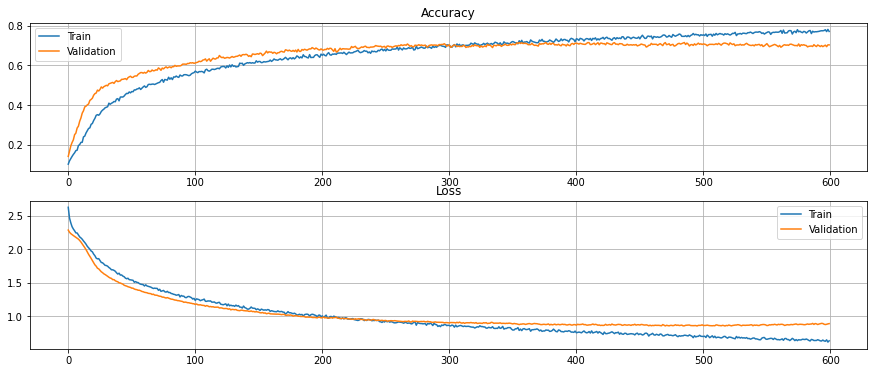

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].title.set_text("Accuracy")
ax[0].plot(running_train_accuracy, label="Train")
ax[0].plot(running_val_acc, label="Validation")
ax[0].grid()
ax[0].legend()
ax[1].title.set_text("Loss")
ax[1].plot(running_train_loss, label="Train")
ax[1].plot(running_val_loss, label="Validation")
ax[1].grid()
ax[1].legend()

plt.show()

8. Evaluati modelul (eroare, acuratete, macro-f1, etc.) pe datele de test.

In [9]:
import sklearn.metrics as metrics

# datele de test
print(f"Test data:   {X_test.shape[0]}")

# print labelurile
print(f"Test labels: {Y_test.shape[0]}")

labels = []
predictions = []

best_network.eval()
with th.no_grad():
    for test_x, test_y in test_dataloader:
        output = network(test_x)
        preds = th.argmax(output, dim=1)

        labels.append(test_y)
        predictions.append(preds)

# concatenam toate nimi-batchurile
labels = th.concat(labels)
predictions = th.concat(predictions)

# convertim la np
labels = labels.numpy()
predictions = predictions.numpy()

print(
    f"Accuracy: {metrics.accuracy_score(labels, predictions)}\n"
    f"Precision: {metrics.precision_score(labels, predictions, average='macro')}\n"
    f"Recall: {metrics.recall_score(labels, predictions, average='macro')}\n"
    f"F1: {metrics.f1_score(labels, predictions, average='macro')}\n"
)


Test data:   1000
Test labels: 1000
Accuracy: 0.679
Precision: 0.6800268854289322
Recall: 0.6785386438885925
F1: 0.6787914365774567



9. Incercati sa adaugati dupa fiecare layer din model (cu exceptia ultimului) dropout cu un $p$ ales de voi. Analizati daca performanta unui model antrenat astfel este mai buna.

In [10]:
# Am facut deja dropout in modelul original,
# asa ca voi incerca sa fac un model FARA dropout.

class NetwNoDropout(th.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[1], 128),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(128, np.unique(Y).shape[0])
        )
        # nu adaugam softmax pentru ca asa ne cere CrossEntropyLoss

    def forward(self, x):
        return self.net(x)

# network
network_no_dropout = NetwNoDropout()

# optimizer
optimizer_no_dropout = th.optim.Adam(network_no_dropout.parameters(), lr=1e-4)

best_val_accuracy = 0.
best_network = None

# aici salvam date despre mini-batchuri
running_train_loss_no_dropout = []
running_train_accuracy_no_dropout = []
running_val_loss_no_dropout = []
running_val_acc_no_dropout = []

In [11]:
# antrenam modelul fara dropout
print("Training model...")
for epoch in range(600):
    print(f"Epoch #{epoch + 1}:")

    epoch_train_losses = []
    epoch_train_acc = []
    network_no_dropout.train()

    for train_x, train_y in train_dataloader:
        optimizer_no_dropout.zero_grad()
        output = network_no_dropout(train_x)
        loss = cross_entropy_loss(output, train_y)
        loss.backward()
        optimizer_no_dropout.step()

        predicted = output.argmax(dim=1)
        epoch_train_acc.append(th.sum(predicted == train_y) / train_x.shape[0])
        epoch_train_losses.append(loss.item())

    avg_train_loss = np.mean(np.array(epoch_train_losses))
    avg_train_acc = np.mean(np.array(epoch_train_acc)
    )
    val_acc, val_loss = [], []

    with th.no_grad():
        network_no_dropout.eval()
        for val_x, val_y in val_dataloader:
            output = network_no_dropout(val_x)
            predicted = output.argmax(dim=1)
            val_acc.append(th.sum(predicted == val_y) / val_x.shape[0])
            val_loss.append(cross_entropy_loss(output, val_y))
    
    val_acc = np.average(np.array(val_acc))
    val_loss = np.average(np.array(val_loss))

    print(f"  Average train loss:          {avg_train_loss}")
    print(f"  Average train accuracy:      {avg_train_acc}")
    print(f"  Average validation loss:     {val_loss}")
    print(f"  Average validation accuracy: {val_acc}")

    running_train_loss_no_dropout.append(avg_train_loss)
    running_train_accuracy_no_dropout.append(avg_train_acc)
    running_val_acc_no_dropout.append(val_acc)
    running_val_loss_no_dropout.append(val_loss)

Training model...
Epoch #1:
  Average train loss:          2.3110176372528075
  Average train accuracy:      0.12099999934434891
  Average validation loss:     2.2427358627319336
  Average validation accuracy: 0.16816405951976776
Epoch #2:
  Average train loss:          2.1892223262786867
  Average train accuracy:      0.20874999463558197
  Average validation loss:     2.155658483505249
  Average validation accuracy: 0.23320312798023224
Epoch #3:
  Average train loss:          2.0812720422744753
  Average train accuracy:      0.296875
  Average validation loss:     2.0624442100524902
  Average validation accuracy: 0.29667967557907104
Epoch #4:
  Average train loss:          1.9617193727493285
  Average train accuracy:      0.36262500286102295
  Average validation loss:     1.9562920331954956
  Average validation accuracy: 0.3486328125
Epoch #5:
  Average train loss:          1.8325897274017333
  Average train accuracy:      0.41499999165534973
  Average validation loss:     1.849240303

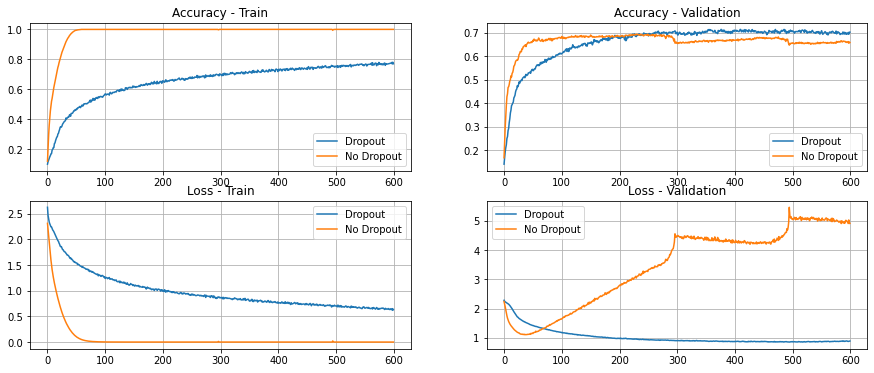

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

ax[0][0].title.set_text("Accuracy - Train")
ax[0][0].plot(running_train_accuracy, label="Dropout")
ax[0][0].plot(running_train_accuracy_no_dropout, label="No Dropout")
ax[0][0].grid()
ax[0][0].legend()


ax[0][1].title.set_text("Accuracy - Validation")
ax[0][1].plot(running_val_acc, label="Dropout")
ax[0][1].plot(running_val_acc_no_dropout, label="No Dropout")
ax[0][1].grid()
ax[0][1].legend()


ax[1][0].title.set_text("Loss - Train")
ax[1][0].plot(running_train_loss, label="Dropout")
ax[1][0].plot(running_train_loss_no_dropout, label="No Dropout")
ax[1][0].grid()
ax[1][0].legend()


ax[1][1].title.set_text("Loss - Validation")
ax[1][1].plot(running_val_loss, label="Dropout")
ax[1][1].plot(running_val_loss_no_dropout, label="No Dropout")
ax[1][1].grid()
ax[1][1].legend()

plt.show()

Uitandu-ne la graficul de mai sus, pare ca am fi putut antrena mai mult reteaua pe modelul cu dropout (modelul fara dropout reuseste sa diferentieze perfect toate cele 10 clase).